Found 4 file(s)



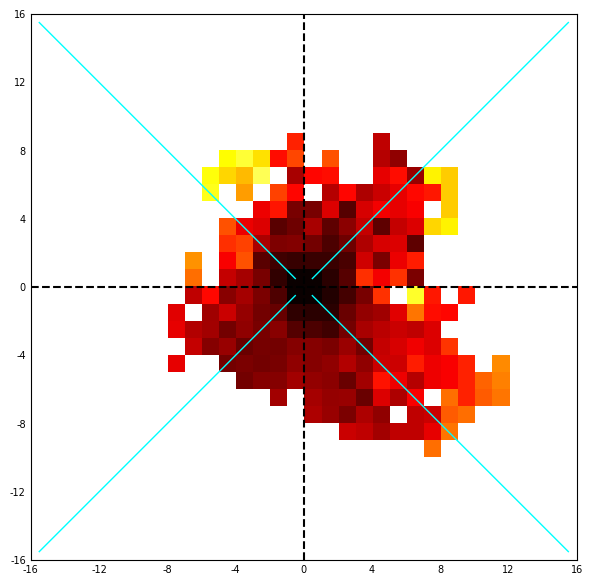

34 x 34--Green Wool = Leaves average of 10, 10s interval.npy
34 x 34--Green Wool = Leaves average of 10, 10s interval.npy
  NW: 7.8567 m min⁻¹
  NE: 33.9411 m min⁻¹
  SW: 30.8556 m min⁻¹
  SE: 17.8638 m min⁻¹



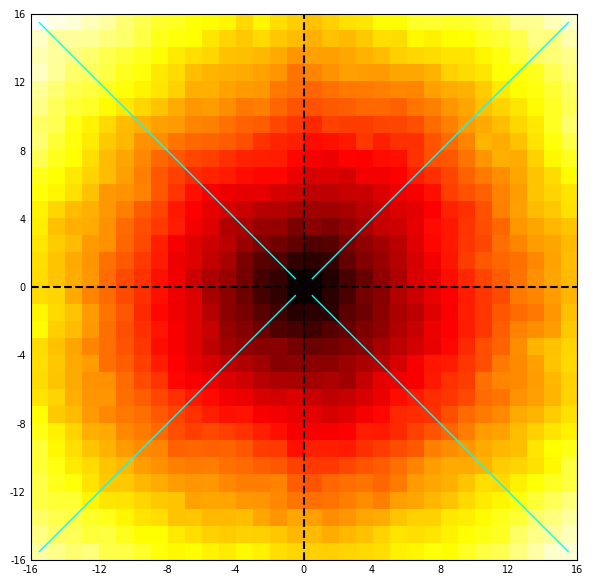

34 x 34--Green Leaves - V4 Remove Adj MaxAge Fire average of 10, 10s interval.npy
34 x 34--Green Leaves - V4 Remove Adj MaxAge Fire average of 10, 10s interval.npy
  NW: 21.3198 m min⁻¹
  NE: 22.4083 m min⁻¹
  SW: 23.4400 m min⁻¹
  SE: 22.2906 m min⁻¹



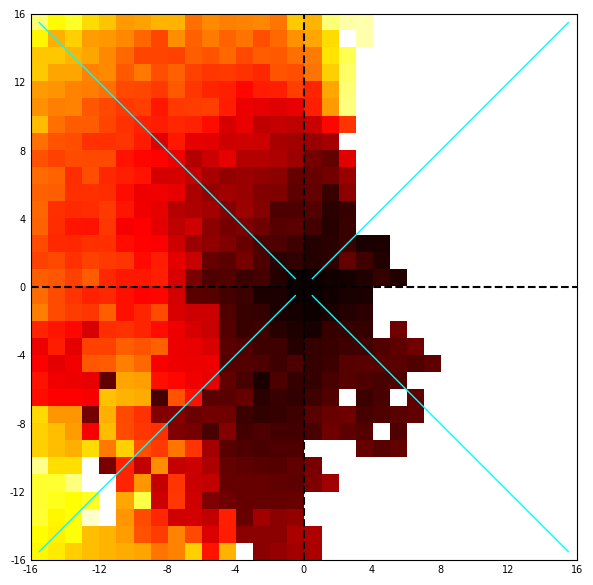

34 x 34--QUAD, 1 Log, 2 Bush, 3 Hay, 4 Leaves average of 4, 10s interval.npy
34 x 34--QUAD, 1 Log, 2 Bush, 3 Hay, 4 Leaves average of 4, 10s interval.npy
  NW: 7.0320 m min⁻¹
  NE: 10.9488 m min⁻¹
  SW: 8.1852 m min⁻¹
  SE: 18.5133 m min⁻¹



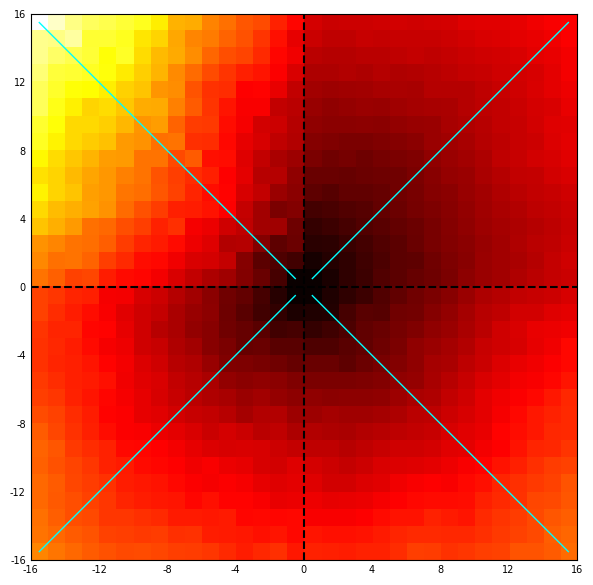

34 x 34--QUAD, 1 Log, 2 Bush, 3 Hay, 4 Leaves - V4 Remove Adj MaxAge Fire average of 10, 10s interval.npy
34 x 34--QUAD, 1 Log, 2 Bush, 3 Hay, 4 Leaves - V4 Remove Adj MaxAge Fire average of 10, 10s interval.npy
  NW: 10.2479 m min⁻¹
  NE: 28.2216 m min⁻¹
  SW: 18.1568 m min⁻¹
  SE: 19.4617 m min⁻¹

📄  CSV saved → C:\Users\samih\OneDrive - Imperial College London\Year 4\FYP\Sami Haque\Technical\Modding\Computer-Vision-for-Fire-Mod\AVERAGED Arrival Matrices\OG_vs_V4_ros_diagonals_2x2.csv


In [23]:
# === 2 × 2-core diagonal ROS (edges-aligned axes) ===========================
# Outputs in m min⁻¹, CSV arranged with fuel types (diagonals) in rows:
#       Fuel type | <file 1> | <file 2> | …
# Order of diagonals: NW, NE, SW, SE  (reading order: top-left → bottom-right)
# ============================================================================
# Imports & USER CONFIG ------------------------------------------------------
import csv
import re
from math import sqrt
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# ---------- USER EDITABLE ---------------------------------------------------
DATA_DIR = Path(
    r"C:\Users\samih\OneDrive - Imperial College London\Year 4\FYP"
    r"\Sami Haque\Technical\Modding\Computer-Vision-for-Fire-Mod\AVERAGED Arrival Matrices"
)
BLOCK_SIZE_M = 1.0                       # one Minecraft block (metres)

# TARGETS = []                           # [] → analyse every .npy in DATA_DIR
TARGETS = [
    r"34 x 34--Green Wool = Leaves average of 10, 10s interval.npy",
    r"34 x 34--Green Leaves - V4 Remove Adj MaxAge Fire average of 10, 10s interval.npy",
    r"34 x 34--QUAD, 1 Log, 2 Bush, 3 Hay, 4 Leaves average of 4, 10s interval.npy",
    r"34 x 34--QUAD, 1 Log, 2 Bush, 3 Hay, 4 Leaves - V4 Remove Adj MaxAge Fire average of 10, 10s interval.npy",
    # r"34 x 34--Sample 100% Spread Chance arrival average of 1, 10s interval.npy",
]

SAVE_CSV   = True                       # True → write summary CSV as below
CSV_NAME   = "OG_vs_V4_ros_diagonals_2x2.csv"
# ----------------------------------------------------------------------------

# ── helpers -----------------------------------------------------------------
def _natural_key(s: str):
    """Sort so ‘v9’ < ‘v10’ etc."""
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def list_files(folder: Path, tgt):
    """Return the .npy files to process in a natural sort order."""
    return ([(folder / t).resolve() for t in tgt] if tgt
            else sorted(folder.glob("*.npy"), key=lambda p: _natural_key(p.name)))

# ── diagonal extraction from a 2 × 2 core -----------------------------------
def extract_diag_from_core(arr: np.ndarray, dx: int, dy: int) -> np.ndarray:
    """
    Extract ignition-time values along one diagonal of the 2 × 2 centre core.
    (dx, dy) identifies the direction: e.g. (-1,-1)=NW, (1,1)=SE, etc.
    """
    h, w = arr.shape
    cx, cy = w // 2, h // 2              # lower-right ignition cell index
    x0 = cx     if dx == 1 else cx - 1
    y0 = cy - 1 if dy == -1 else cy
    vals, x, y = [], x0, y0
    while 0 <= x < w and 0 <= y < h:
        vals.append(arr[y, x])
        x += dx
        y += dy
    return np.asarray(vals)

# ── ROS calculation (m min⁻¹) ----------------------------------------------
SECONDS_TO_MIN = 60.0                    # conversion factor

def ros(diag_times: np.ndarray) -> float:
    """
    Head-fire rate of spread along a diagonal, returned in metres per minute.
    NaN is returned if there are fewer than two finite data points.
    """
    idx = np.where(np.isfinite(diag_times))[0]
    if len(idx) < 2:
        return np.nan
    t0, tn = diag_times[idx[0]], diag_times[idx[-1]]
    steps  = idx[-1]                     # moves of √2 blocks
    dist   = steps * BLOCK_SIZE_M * sqrt(2)
    dt     = tn - t0
    if dt <= 0:
        return np.nan
    return (dist / dt) * SECONDS_TO_MIN  # m min⁻¹

# ── optional plotting helper ------------------------------------------------
def plot_overlay(arr: np.ndarray, title: str = ""):
    """Heat-map with cyan diagonals; axes on cell edges (ticks −16…16)."""
    data = arr[1:-1, 1:-1]               # 32 × 32 inner grid
    h, w = data.shape
    cx, cy = w // 2, h // 2

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(data, cmap="hot", interpolation="nearest")

    # four diagonals in cyan
    for dx, dy in [(1, -1), (-1, -1), (1, 1), (-1, 1)]:
        x0 = cx if dx == 1 else cx - 1
        y0 = cy - 1 if dy == -1 else cy
        xs, ys, x, y = [x0], [y0], x0, y0
        while 0 <= x + dx < w and 0 <= y + dy < h:
            x += dx
            y += dy
            xs.append(x)
            ys.append(y)
        ax.plot(xs, ys, color="cyan", lw=1)

    desired = np.arange(-16, 17, 4)      # tick positions on edges
    x_pos = cx + desired - 0.5
    y_pos = cy - desired - 0.5
    ax.set_xticks(x_pos)
    ax.set_xticklabels(desired, fontsize=7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(desired, fontsize=7)

    ax.axvline(cx - 0.5, color="black", ls="--")
    ax.axhline(cy - 0.5, color="black", ls="--")

    ax.set_xlim(-0.5, w - 0.5)
    ax.set_ylim(h - 0.5, -0.5)
    ax.tick_params(axis="both", length=0)
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()
    if title:
        print(title)

# ── main loop ---------------------------------------------------------------
DIR_VECTORS = [(-1, -1), (1, -1), (-1, 1), (1, 1)]  # NW, NE, SW, SE
DIR_LABELS  = ["NW", "NE", "SW", "SE"]              # rename if you wish

files = list_files(DATA_DIR, TARGETS)
if not files:
    raise FileNotFoundError("No .npy files matched your TARGETS / DATA_DIR set-up.")

print(f"Found {len(files)} file(s)\n")

# Collect results per diagonal
results = {lab: [] for lab in DIR_LABELS}

for p in files:
    arr = np.load(p)
    # calculate ROS for each diagonal
    for (dx, dy), lab in zip(DIR_VECTORS, DIR_LABELS):
        val = ros(extract_diag_from_core(arr, dx, dy))
        results[lab].append(val)

    # optional visual check
    plot_overlay(arr, title=p.name)

    # quick terminal read-out
    print(p.name)
    for lab in DIR_LABELS:
        v = results[lab][-1]
        print(f"  {lab}: {v:.4f} m min⁻¹" if np.isfinite(v) else f"  {lab}: NaN")
    print()

# ── optional CSV ------------------------------------------------------------
if SAVE_CSV:
    out = DATA_DIR / CSV_NAME
    with open(out, "w", newline="") as f:
        writer = csv.writer(f)
        # header row
        writer.writerow(["Fuel type", *[p.name for p in files]])
        # each row corresponds to one diagonal
        for lab in DIR_LABELS:           # NW → NE → SW → SE
            row = [lab] + [
                f"{v:.6f}" if np.isfinite(v) else "" for v in results[lab]
            ]
            writer.writerow(row)
    print("📄  CSV saved →", out)
